In [98]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [ ]:
data = pd.read_csv("la_temperature.csv", parse_dates=["time"], 
                   index_col="time")
data.head()

,tavg
time,
2019-06-19,20.4
2019-06-20,19.7
2019-06-21,19.0
2019-06-22,19.8
2019-06-23,19.5


In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data['tavg'].values.reshape(-1, 1))

In [111]:
data["sin_doy"] = np.sin(2 * np.pi * data.index.dayofyear / 365)
data["cos_doy"] = np.cos(2 * np.pi * data.index.dayofyear / 365)

features = np.hstack([
    scaled, 
    data["sin_doy"].values.reshape(-1, 1),
    data["cos_doy"].values.reshape(-1, 1)
])


In [101]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

In [116]:
window_size = 30
X_arr, y_arr = create_sequences(features, window_size)

# Train/Val split
split = int(0.8 * len(X_arr))
X_train, X_val = X_arr[:split], X_arr[split:]
y_train, y_val = y_arr[:split], y_arr[split:]

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


In [121]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)       # out: (batch, seq_len, hidden_size)
        last = out[:, -1, :]        # (batch, hidden_size)
        return self.fc(last).squeeze(-1)        # (batch, 1)


In [127]:
model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# --- 3. Train & Validate ---
best_val = float("inf")
for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        pred = model(xb).unsqueeze(-1)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb).unsqueeze(-1)
            val_losses.append(loss_fn(pred, yb).item())
    avg_val = np.mean(val_losses)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Val Loss: {avg_val:.4f}")
    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(), "best_lstm.pth")


c:\Users\frang\new_git\weather_bayes\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 3])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\frang\new_git\weather_bayes\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([19, 3])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\frang\new_git\weather_bayes\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([5, 3])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting

Epoch 0, Val Loss: 0.6384
Epoch 10, Val Loss: 0.6335
Epoch 20, Val Loss: 0.6317
Epoch 30, Val Loss: 0.6273
Epoch 40, Val Loss: 0.6258
Epoch 50, Val Loss: 0.6258
Epoch 60, Val Loss: 0.6258
Epoch 70, Val Loss: 0.6256
Epoch 80, Val Loss: 0.6254
Epoch 90, Val Loss: 0.6255


In [128]:
# Load best model
model.load_state_dict(torch.load("best_lstm.pth"))

# --- 4. Forecast Next 200 Days ---
model.eval()
last_seq = features[-window_size:]  # shape [30, 3]
forecasts_scaled = []
input_seq = last_seq.copy()
for _ in range(200):
    tensor_in = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # [1,30,3]
    with torch.no_grad():
        pred_scaled = model(tensor_in).item()
    forecasts_scaled.append(pred_scaled)
    # Update input_seq: drop first row, append new features
    next_sin = np.sin(2 * np.pi * ((data.index[-1].dayofyear + len(forecasts_scaled)) % 365) / 365)
    next_cos = np.cos(2 * np.pi * ((data.index[-1].dayofyear + len(forecasts_scaled)) % 365) / 365)
    input_seq = np.vstack([
        input_seq[1:], 
        [pred_scaled, next_sin, next_cos]
    ])

# Inverse scale only the temperature dimension
forecasts_scaled_arr = np.array(forecasts_scaled).reshape(-1,1)
forecasted_temps = scaler.inverse_transform(
    np.hstack((forecasts_scaled_arr, 
               np.zeros((200, 2)))  # dummy sin/cos columns so scaler works
    )
)[:,0]


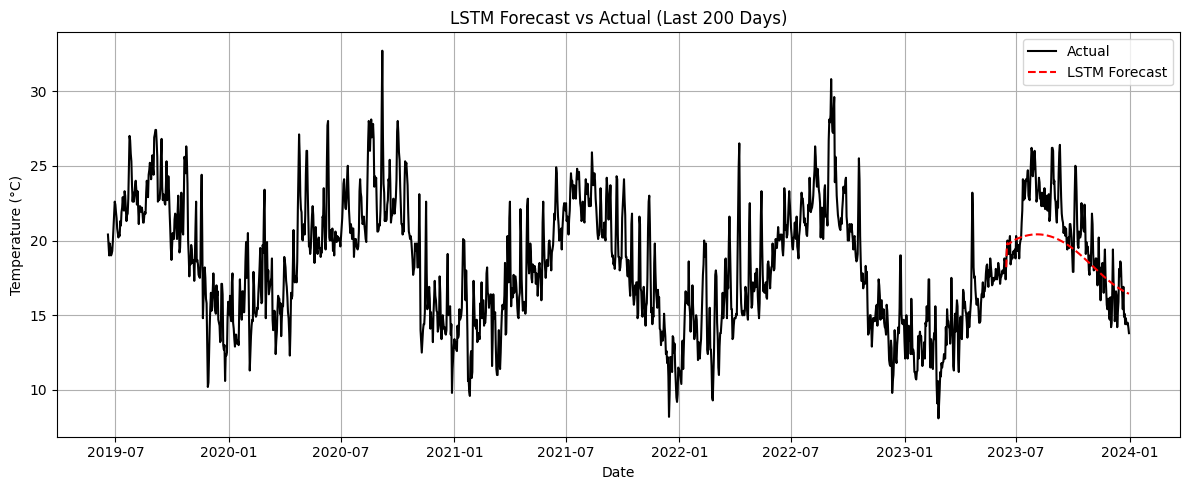

In [130]:
last_dates = data.index[-200:]
true_last200 = data["tavg"].values[-200:]

plt.figure(figsize=(12, 5))
plt.plot(data.index, data['tavg'], label="Actual", color='black')
plt.plot(last_dates, forecasted_temps, label="LSTM Forecast", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("LSTM Forecast vs Actual (Last 200 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()